<a href="https://colab.research.google.com/github/OshiniBandara/Computer_Vision_Assignment/blob/main/Computer_Vision_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Question 01**

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open('/a1images/emma.jpg').convert("L")
pixel_array = np.array(img)

output_pixels = np.zeros_like(pixel_array, dtype=np.uint8)

In [ ]:
mask_low_range = pixel_array < 50
output_pixels[mask_low_range] = pixel_array[mask_low_range]

mask_mid_range = (pixel_array >= 50) & (pixel_array < 150)
output_pixels[mask_mid_range] = (
    100 + (pixel_array[mask_mid_range] - 50) * (155 // 100)
)

mask_high_range = pixel_array >= 150
output_pixels[mask_high_range] = pixel_array[mask_high_range]

In [ ]:
transformed_image = Image.fromarray(output_pixels)

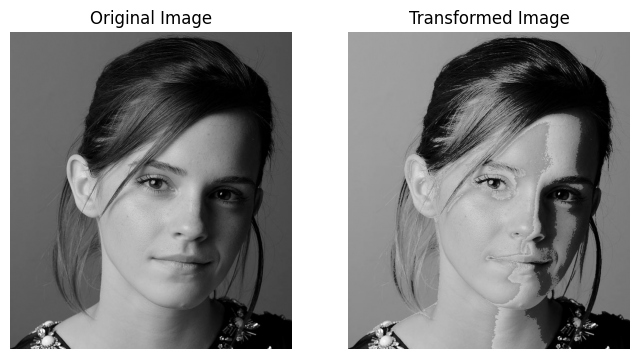

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(pixel_array, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(output_pixels, cmap="gray")
plt.title("Transformed Image")
plt.axis("off")

plt.show()

**Question 02**

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def compute_non_background_percentiles(image_uint8, background_threshold=5):

    all_pixels = image_uint8.ravel()
    foreground_pixels = all_pixels[all_pixels > background_threshold]
    return np.percentile(foreground_pixels, [10, 35, 50, 60, 80, 90])

def create_window_lookup_table(window_min, window_max,
                               output_min=0, output_max=255,
                               outside_slope_ratio=0.05):

    x = np.arange(256, dtype=np.float32)
    inside_slope = (output_max - output_min) / max(window_max - window_min, 1e-6)
    outside_slope = outside_slope_ratio * inside_slope

    lut = np.zeros_like(x)
    below = x < window_min
    inside = (x >= window_min) & (x <= window_max)
    above = x > window_max

    lut[below]  = output_min + outside_slope * (x[below] - window_min)
    lut[inside] = output_min + inside_slope   * (x[inside] - window_min)
    lut[above]  = output_max + outside_slope * (x[above] - window_max)

    return np.clip(lut, 0, 255).astype(np.uint8)

def apply_lut(image_uint8, lut):

    return lut[image_uint8]


image_path = '/a1images/brain_proton_density_slice.png'
brain_image = Image.open(image_path).convert("L")
brain_array = np.array(brain_image)

p10, p35, p50, p60, p80, p90 = compute_non_background_percentiles(brain_array)

white_matter_range = (int(p35), int(p60))
gray_matter_range  = (int(p60), int(p80))

white_matter_lut = create_window_lookup_table(*white_matter_range)
gray_matter_lut  = create_window_lookup_table(*gray_matter_range)

white_matter_contrast = apply_lut(brain_array, white_matter_lut)
gray_matter_contrast  = apply_lut(brain_array, gray_matter_lut)


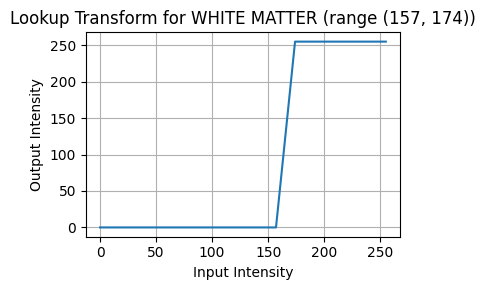

In [ ]:
x = np.arange(256)

plt.figure(figsize=(4, 3))
plt.plot(x, white_matter_lut)
plt.title(f"Lookup Transform for WHITE MATTER (range {white_matter_range})")
plt.xlabel("Input Intensity")
plt.ylabel("Output Intensity")
plt.grid(True)
plt.tight_layout()
plt.show()

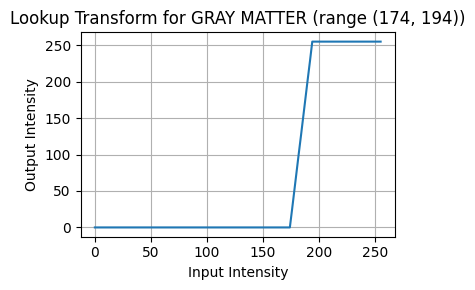

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(x, gray_matter_lut)
plt.title(f"Lookup Transform for GRAY MATTER (range {gray_matter_range})")
plt.xlabel("Input Intensity")
plt.ylabel("Output Intensity")
plt.grid(True)
plt.tight_layout()
plt.show()

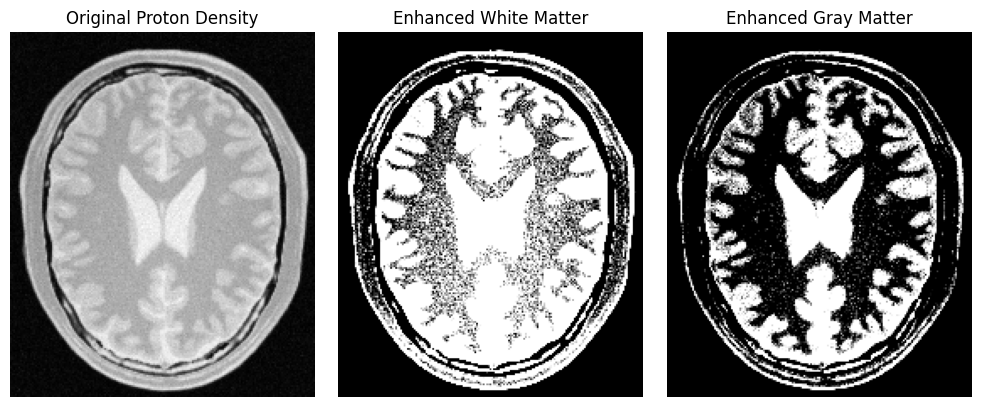

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(brain_array, cmap="gray")
plt.title("Original Proton Density")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(white_matter_contrast, cmap="gray")
plt.title("Enhanced White Matter")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(gray_matter_contrast, cmap="gray")
plt.title("Enhanced Gray Matter")
plt.axis("off")

plt.tight_layout()
plt.show()

**Question 03**

In [ ]:
!pip install opencv-python

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
input_path  = '/a1images/highlights_and_shadows.jpg'
output_path = '/a1images/image_L_gamma_0p8.jpg'
gamma       = 1.0

In [ ]:
bgr_input = cv2.imread(input_path)
if bgr_input is None:
    raise FileNotFoundError(f"Could not read image at: {input_path}")

In [ ]:
lab_input = cv2.cvtColor(bgr_input, cv2.COLOR_BGR2LAB)
l_original_8bit, a_channel_8bit, b_channel_8bit = cv2.split(lab_input)

In [ ]:
l_normalized = l_original_8bit.astype(np.float32) / 255.0
l_gamma_float = (l_normalized ** gamma) * 255.0
l_gamma_8bit = np.clip(l_gamma_float, 0, 255).astype(np.uint8)

lab_gamma_corrected = cv2.merge([l_gamma_8bit, a_channel_8bit, b_channel_8bit])
bgr_output = cv2.cvtColor(lab_gamma_corrected, cv2.COLOR_LAB2BGR)

cv2.imwrite(output_path, bgr_output)

True

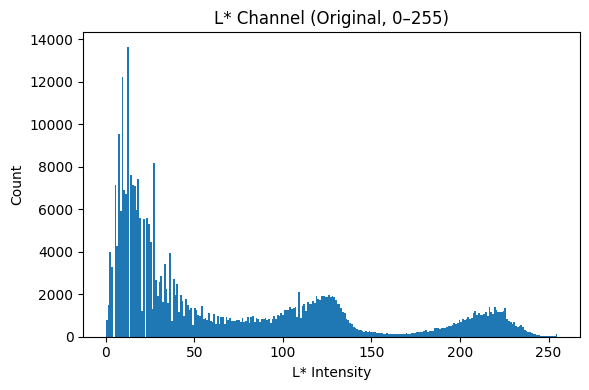

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(l_original_8bit.ravel(), bins=256, range=(0, 255))
plt.title("L* Channel (Original, 0–255)")
plt.xlabel("L* Intensity"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

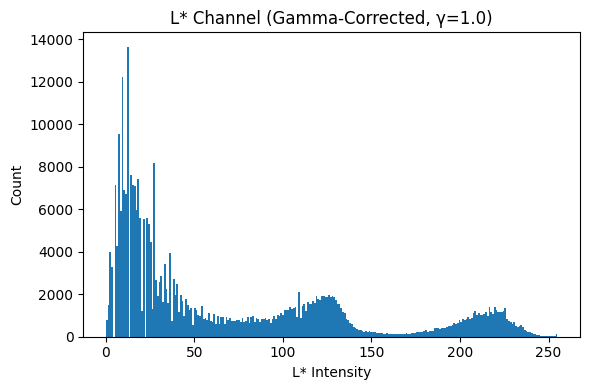

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(l_gamma_8bit.ravel(), bins=256, range=(0, 255))
plt.title(f"L* Channel (Gamma-Corrected, γ={gamma})")
plt.xlabel("L* Intensity"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

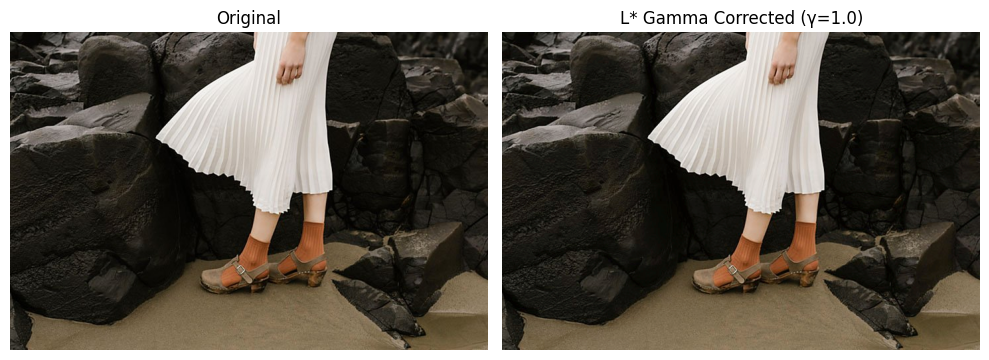

In [ ]:
rgb_input  = cv2.cvtColor(bgr_input,  cv2.COLOR_BGR2RGB)
rgb_output = cv2.cvtColor(bgr_output, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.imshow(rgb_input);  plt.title("Original"); plt.axis("off")
plt.subplot(1, 2, 2); plt.imshow(rgb_output); plt.title(f"L* Gamma Corrected (γ={gamma})"); plt.axis("off")
plt.tight_layout(); plt.show()

**Question 04**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

input_path   = '/a1images/spider.png'
output_path  = '/a1images/spider_vibrance_enhanced.png'
vibrance_amt = 0.65
sigma_value  = 70.0

In [ ]:
bgr_input = cv2.imread(input_path)
if bgr_input is None:
    raise FileNotFoundError(f"Could not read {input_path}")

hsv_input = cv2.cvtColor(bgr_input, cv2.COLOR_BGR2HSV)
hue_plane, sat_plane, val_plane = cv2.split(hsv_input)

sat_float = sat_plane.astype(np.float32)

gaussian_curve = 128.0 * np.exp(-((sat_float - 128.0) ** 2) / (2.0 * sigma_value * sigma_value))

sat_enhanced = np.clip(
    sat_float + vibrance_amt * gaussian_curve,
    0, 255
).astype(np.uint8)

hsv_enhanced = cv2.merge([hue_plane, sat_enhanced, val_plane])
bgr_output   = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2BGR)

cv2.imwrite(output_path, bgr_output)
print(f"[REPORT] Chosen vibrance strength a = {vibrance_amt}")

In [ ]:
rgb_input  = cv2.cvtColor(bgr_input,  cv2.COLOR_BGR2RGB)
rgb_output = cv2.cvtColor(bgr_output, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.imshow(rgb_input);  plt.title("Original"); plt.axis("off")
plt.subplot(1, 2, 2); plt.imshow(rgb_output); plt.title(f"Vibrance (a={vibrance_amt}, σ={int(sigma_value)})"); plt.axis("off")
plt.tight_layout(); plt.show()

In [ ]:
s_in_values  = np.arange(256, dtype=np.float32)
bump_curve   = 128.0 * np.exp(-((s_in_values - 128.0) ** 2) / (2.0 * sigma_value * sigma_value))
s_out_values = np.minimum(s_in_values + vibrance_amt * bump_curve, 255.0)

plt.figure(figsize=(6, 4))
plt.plot(s_in_values, s_out_values)
plt.title(f"Saturation Transform (a={vibrance_amt}, σ={int(sigma_value)})")
plt.xlabel("Input Saturation (0–255)")
plt.ylabel("Output Saturation (0–255)")
plt.grid(True)
plt.tight_layout()
plt.show()

**Question 05**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
input_path  = '/a1images/jeniffer.jpg'
output_path = '/a1images/jenniffer_foreground_hist_e.jpg'

bgr_input = cv2.imread(input_path)
if bgr_input is None:
    raise FileNotFoundError(f"Cannot read image {input_path}")

hsv_input = cv2.cvtColor(bgr_input, cv2.COLOR_BGR2HSV)
hue_channel, sat_channel, val_channel = cv2.split(hsv_input)

otsu_thresh, mask_foreground = cv2.threshold(
    sat_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask_foreground = cv2.morphologyEx(mask_foreground, cv2.MORPH_CLOSE, kernel, 1)
mask_foreground = cv2.morphologyEx(mask_foreground, cv2.MORPH_OPEN,  kernel, 1)

In [ ]:
hist_foreground_before = cv2.calcHist(
    images=[val_channel], channels=[0],
    mask=mask_foreground, histSize=[256], ranges=[0, 256]
).flatten().astype(np.int64)

cdf_foreground = np.cumsum(hist_foreground_before).astype(np.float64)
if cdf_foreground[-1] > 0:
    cdf_min = cdf_foreground[cdf_foreground > 0][0]
    lut = np.floor((cdf_foreground - cdf_min) * 255.0 / (cdf_foreground[-1] - cdf_min + 1e-9))
else:
    lut = np.zeros(256)
lut_foreground = np.clip(lut, 0, 255).astype(np.uint8)

val_equalized = val_channel.copy()
val_equalized[mask_foreground == 255] = lut_foreground[val_channel[mask_foreground == 255]]

hsv_equalized = cv2.merge([hue_channel, sat_channel, val_equalized])
bgr_output = cv2.cvtColor(hsv_equalized, cv2.COLOR_HSV2BGR)
cv2.imwrite(output_path, bgr_output)

In [ ]:
rgb_input  = cv2.cvtColor(bgr_input,  cv2.COLOR_BGR2RGB)
rgb_output = cv2.cvtColor(bgr_output, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes[0,0].imshow(hue_channel, cmap="gray"); axes[0,0].set_title("Hue (0–179)"); axes[0,0].axis("off")
axes[0,1].imshow(sat_channel, cmap="gray"); axes[0,1].set_title("Saturation (0–255)"); axes[0,1].axis("off")
axes[0,2].imshow(val_channel, cmap="gray"); axes[0,2].set_title("Value (0–255)"); axes[0,2].axis("off")
axes[1,0].imshow(mask_foreground, cmap="gray"); axes[1,0].set_title("Foreground Mask"); axes[1,0].axis("off")
axes[1,1].imshow(rgb_input);  axes[1,1].set_title("Original"); axes[1,1].axis("off")
axes[1,2].imshow(rgb_output); axes[1,2].set_title("Foreground Equalized"); axes[1,2].axis("off")
plt.tight_layout(); plt.show()

In [ ]:
hist_foreground_after = cv2.calcHist(
    images=[val_equalized], channels=[0],
    mask=mask_foreground, histSize=[256], ranges=[0, 256]
).flatten()

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.bar(np.arange(256), hist_foreground_before, width=1); ax1.set_title("Foreground V (Before)")
ax2.bar(np.arange(256), hist_foreground_after,  width=1); ax2.set_title("Foreground V (After)")
for ax in (ax1, ax2):
    ax.set_xlabel("Value Channel (0–255)"); ax.set_ylabel("Count")
plt.tight_layout(); plt.show()

**Question 06**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

input_path = '/a1images/einstein.png'
gray_img: np.ndarray = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

In [ ]:
def normalize_for_display(array: np.ndarray) -> np.ndarray:
    array_abs = np.abs(array)
    array_norm = array_abs / (array_abs.max() + 1e-9)
    return (255 * array_norm).astype(np.uint8)

sobel_x: np.ndarray = np.array([[1, 0, -1],
                                [2, 0, -2],
                                [1, 0, -1]], dtype=np.float32)
sobel_y: np.ndarray = sobel_x.T  # transpose

grad_x_cv2: np.ndarray = cv2.filter2D(gray_img, cv2.CV_64F, sobel_x, borderType=cv2.BORDER_REPLICATE)
grad_y_cv2: np.ndarray = cv2.filter2D(gray_img, cv2.CV_64F, sobel_y, borderType=cv2.BORDER_REPLICATE)
mag_cv2:   np.ndarray = np.hypot(grad_x_cv2, grad_y_cv2)

In [ ]:
def convolve2d_manual(img: np.ndarray, kernel: np.ndarray) -> np.ndarray:

    k_h, k_w = kernel.shape
    pad_y, pad_x = k_h // 2, k_w // 2

    padded = np.pad(img, ((pad_y, pad_y), (pad_x, pad_x)), mode="edge")
    output = np.zeros_like(img, dtype=np.float32)

    h, w = img.shape
    for y in range(h):
        for x in range(w):
            window = padded[y:y + k_h, x:x + k_w]
            output[y, x] = np.sum(window * kernel)
    return output

grad_x_manual: np.ndarray = convolve2d_manual(gray_img, sobel_x)
grad_y_manual: np.ndarray = convolve2d_manual(gray_img, sobel_y)
mag_manual:   np.ndarray = np.hypot(grad_x_manual, grad_y_manual)

In [ ]:
smooth_1d: np.ndarray = np.array([1, 2, 1], dtype=np.float32)
deriv_1d:  np.ndarray = np.array([1, 0, -1], dtype=np.float32)

grad_x_sep: np.ndarray = cv2.sepFilter2D(gray_img, cv2.CV_64F, deriv_1d, smooth_1d)
grad_y_sep: np.ndarray = cv2.sepFilter2D(gray_img, cv2.CV_64F, smooth_1d, deriv_1d)
mag_sep:   np.ndarray = np.hypot(grad_x_sep, grad_y_sep)


In [ ]:
titles = ["(a) |G| filter2D", "(b) |G| manual", "(c) |G| separable", "Original"]
images = [normalize_for_display(mag_cv2),
          normalize_for_display(mag_manual),
          normalize_for_display(mag_sep),
          gray_img.astype(np.uint8)]

plt.figure(figsize=(8, 8))
for idx, (title, img) in enumerate(zip(titles, images), start=1):
    plt.subplot(2, 2, idx)
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
plt.tight_layout()
plt.show()

**Question 07**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def zoom_image(image: np.ndarray, scale: float, method: str = "nearest") -> np.ndarray:
    """Upscale image by factor (0 < scale ≤ 10) using nearest or bilinear interpolation."""

    # Validate inputs
    if not (0 < scale <= 10):
      raise ValueError(f"Invalid scale factor: {scale}. Must be greater than 0 and less than or equal to 10.")

    if method not in {"nearest", "bilinear"}:
      raise ValueError(f"Invalid interpolation method: '{method}'. Supported options are 'nearest' and 'bilinear'.")

    # Ensure float32 and unify shape to (H, W, C)
    src = image.astype(np.float32)
    if src.ndim == 2:
        src = src[..., None]

    in_h, in_w, channels = src.shape
    out_h = int(round(in_h * scale))
    out_w = int(round(in_w * scale))

    # Map output pixel centers → source coords (half-pixel rule)
    src_y = (np.arange(out_h, dtype=np.float32) + 0.5) / scale - 0.5
    src_x = (np.arange(out_w, dtype=np.float32) + 0.5) / scale - 0.5

    # Keep inside bounds
    src_y = np.clip(src_y, 0, in_h - 1)
    src_x = np.clip(src_x, 0, in_w - 1)

    # --- Nearest Neighbor ---
    if method == "nearest":
        y_idx = np.rint(src_y).astype(np.int32)
        x_idx = np.rint(src_x).astype(np.int32)
        out_float = src[y_idx[:, None], x_idx[None, :], :]

    # --- Bilinear Interpolation ---
    else:
        y0 = np.floor(src_y).astype(np.int32)
        x0 = np.floor(src_x).astype(np.int32)
        y1 = np.clip(y0 + 1, 0, in_h - 1)
        x1 = np.clip(x0 + 1, 0, in_w - 1)

        wy = (src_y - y0).reshape(-1, 1, 1)  # (Hout,1,1)
        wx = (src_x - x0).reshape(1, -1, 1)  # (1,Wout,1)

        # Gather 4 neighbors
        tl = src[y0[:, None], x0[None, :], :]
        tr = src[y0[:, None], x1[None, :], :]
        bl = src[y1[:, None], x0[None, :], :]
        br = src[y1[:, None], x1[None, :], :]

        # Blend horizontally then vertically
        top    = (1 - wx) * tl + wx * tr
        bottom = (1 - wx) * bl + wx * br
        out_float = (1 - wy) * top + wy * bottom

    # Final: clip, cast back to uint8, squeeze grayscale
    out_uint8 = np.clip(out_float, 0, 255).astype(np.uint8)
    return out_uint8[..., 0] if out_uint8.shape[2] == 1 else out_uint8

In [ ]:
def normalized_ssd(img_a: np.ndarray, img_b: np.ndarray) -> float:
    """Normalized mean squared difference in [0,1]."""
    if img_a.shape != img_b.shape:
        raise ValueError(
        f"Images must have the same shape for SSD. "
        f"Got {img_a.shape} vs {img_b.shape}.")
    diff = img_a.astype(np.float32) - img_b.astype(np.float32)
    return float(np.mean(diff**2) / (255.0**2))

original = cv2.imread('/a1images/im01.png')
small    = cv2.imread('/a1images/im01small.png')

scale_factor = 4.0
up_nearest  = zoom_image(small, scale_factor, method="nearest")
up_bilinear = zoom_image(small, scale_factor, method="bilinear")

print(f"Normalized SSD using Nearest Neighbor Interpolation : {normalized_ssd(original, up_nearest):.6f}")
print(f"Normalized SSD using Bilinear Interpolation        : {normalized_ssd(original, up_bilinear):.6f}")

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title("Original"); plt.axis("off")

plt.subplot(1, 3, 2); plt.imshow(cv2.cvtColor(up_nearest, cv2.COLOR_BGR2RGB))
plt.title("Upscaled ×4 (Nearest)"); plt.axis("off")

plt.subplot(1, 3, 3); plt.imshow(cv2.cvtColor(up_bilinear, cv2.COLOR_BGR2RGB))
plt.title("Upscaled ×4 (Bilinear)"); plt.axis("off")
plt.tight_layout(); plt.show()

**Question 08**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
input_path = '/a1images/daisy.jpg'
original_bgr = cv2.imread(input_path)

if original_bgr is None:
    raise FileNotFoundError(f"Could not load image: {input_path}")

img_height, img_width = original_bgr.shape[:2]
print(f"Loaded image '{input_path}' with size {img_width}x{img_height}")

In [ ]:
grabcut_rect = (
    int(0.08 * img_width),
    int(0.06 * img_height),
    int(0.84 * img_width),
    int(0.88 * img_height),
)

# Initialize mask and GMMs
grabcut_mask = np.zeros((img_height, img_width), np.uint8)
bg_gmm = np.zeros((1, 65), np.float64)
fg_gmm = np.zeros((1, 65), np.float64)

# Run GrabCut
cv2.grabCut(
    original_bgr, grabcut_mask, grabcut_rect,
    bg_gmm, fg_gmm,
    iterCount=5, mode=cv2.GC_INIT_WITH_RECT
)

# Convert GrabCut labels to binary mask (1=FG, 0=BG)
binary_mask = np.where(
    (grabcut_mask == cv2.GC_FGD) | (grabcut_mask == cv2.GC_PR_FGD), 1, 0
).astype(np.uint8)

# Clean up mask with morphology
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

print("GrabCut segmentation complete.")

In [ ]:
foreground_bgr = cv2.bitwise_and(original_bgr, original_bgr, mask=binary_mask)
background_bgr = cv2.bitwise_and(original_bgr, original_bgr, mask=1 - binary_mask)

print("Extracted foreground and background.")

In [ ]:
blurred_bgr = cv2.GaussianBlur(original_bgr, (0, 0), 10, 10)

# Feather mask for smooth blending
alpha_mask = cv2.GaussianBlur(binary_mask.astype(np.float32), (0, 0), 2)[..., None]

# Composite: sharp foreground over blurred background
composite_bgr = (
    alpha_mask * original_bgr.astype(np.float32)
    + (1 - alpha_mask) * blurred_bgr.astype(np.float32)
).astype(np.uint8)

print("Created blurred-background composite.")

In [ ]:
plt.figure(figsize=(14, 9))

plt.subplot(231); plt.imshow(cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB))
plt.title("Original"); plt.axis("off")

plt.subplot(232); plt.imshow((binary_mask * 255).astype(np.uint8), cmap="gray")
plt.title("Segmentation Mask"); plt.axis("off")

plt.subplot(233); plt.imshow(cv2.cvtColor(foreground_bgr, cv2.COLOR_BGR2RGB))
plt.title("Foreground"); plt.axis("off")

plt.subplot(234); plt.imshow(cv2.cvtColor(background_bgr, cv2.COLOR_BGR2RGB))
plt.title("Background"); plt.axis("off")

plt.subplot(235); plt.imshow(cv2.cvtColor(composite_bgr, cv2.COLOR_BGR2RGB))
plt.title("Enhanced (Blurred BG)"); plt.axis("off")

plt.subplot(236); plt.imshow(cv2.cvtColor(blurred_bgr, cv2.COLOR_BGR2RGB))
plt.title("Full Image Blur"); plt.axis("off")

plt.tight_layout()
plt.show()

**Question 09**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def denoise_image(gray: np.ndarray, noise_type: str) -> np.ndarray:
    if noise_type == "gaussian":
        return cv2.GaussianBlur(gray, (5, 5), 1.0)
    if noise_type == "salt_pepper":
        return cv2.medianBlur(gray, 5)
    raise ValueError(f"Invalid noise_type '{noise_type}'.")

def otsu_binary_mask(gray: np.ndarray) -> tuple[np.ndarray, float]:
    otsu_value, mask = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    return mask, float(otsu_value)

def refine_mask(binary_mask: np.ndarray, min_area: int = 100) -> np.ndarray:
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opened = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel, iterations=1)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(closed, connectivity=8)
    kept = np.zeros_like(closed, dtype=np.uint8)
    for label_id in range(1, num_labels):  # skip background
        if stats[label_id, cv2.CC_STAT_AREA] >= min_area:
            kept[labels == label_id] = 255
    return kept

In [ ]:
def count_grains(binary_mask: np.ndarray) -> int:
    num_labels, _, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    return int(np.sum(stats[1:, cv2.CC_STAT_AREA] > 0))

def display_results(original: np.ndarray, denoised: np.ndarray,
                    otsu_mask: np.ndarray, refined_mask: np.ndarray,
                    title_prefix: str, grain_count: int) -> None:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1); plt.imshow(original, cmap="gray"); plt.title(f"{title_prefix}: Original"); plt.axis("off")
    plt.subplot(1, 4, 2); plt.imshow(denoised, cmap="gray"); plt.title("Denoised"); plt.axis("off")
    plt.subplot(1, 4, 3); plt.imshow(otsu_mask, cmap="gray"); plt.title("Otsu Mask"); plt.axis("off")
    plt.subplot(1, 4, 4); plt.imshow(refined_mask, cmap="gray"); plt.title(f"Refined (count={grain_count})"); plt.axis("off")
    plt.tight_layout(); plt.show()

In [ ]:
gaussian_img_path   = '/a1images/rice_gaussian_noise.png'
saltpepper_img_path = '/a1images/rice_salt_pepper_noise.png'

image_specs = [
    (gaussian_img_path, "gaussian"),
    (saltpepper_img_path, "salt_pepper"),
]

In [ ]:
for path, noise_kind in image_specs:
    gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if gray is None:
        raise FileNotFoundError(f"Could not load {path}")

    denoised = denoise_image(gray, noise_kind)
    otsu_mask, otsu_value = otsu_binary_mask(denoised)
    refined = refine_mask(otsu_mask, min_area=100)
    grain_count = count_grains(refined)

    noise_label = "Gaussian noise" if noise_kind == "gaussian" else "Salt & pepper noise"
    print(f"{path} | Otsu threshold = {otsu_value:.1f} | Estimated grains = {grain_count}")

    display_results(gray, denoised, otsu_mask, refined, noise_label, grain_count)